In [1]:
import pickle
import pandas as pd
import numpy as np

import sys
sys.path.append("C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/src")  # Adjust this path as needed
from metrics import rmse_value, pearson_correlation, snr
from vis import plot_eeg

In [2]:
data_path = "C:/Users/blaze/Desktop/opsi_eeg_denoising/eeg-denoising/data/eeg_dataset_pink.pkl"
with open(data_path, "rb") as f:
    eeg_datasets_dict = pickle.load(f)
#eeg_datasets_dict
results_emd_dataset = eeg_datasets_dict["results_emd_denoising"]
results_eemd_dataset = eeg_datasets_dict["results_eemd_denoising"]
original_eeg_dataset = eeg_datasets_dict["original_eeg"]
results_emd_threshold_dataset = eeg_datasets_dict["results_emd_threshold"]
results_eemd_threshold_dataset = eeg_datasets_dict["results_eemd_threshold"]

In [3]:
original_eeg_dataset["dataset_original"].keys()

dict_keys(['channel_names', 'original_scaled_eeg'])

In [4]:
original_eeg = original_eeg_dataset["dataset_original"]["original_scaled_eeg"]
channel_names = original_eeg_dataset["dataset_original"]["channel_names"]
noisy_eeg = original_eeg_dataset["dataset_noisy"]["noisy_scaled_eeg"]

# Evaluation

In [5]:
#Calculating Metrics for EMD

metrics_results = pd.DataFrame(columns=["IMFs removed", 'rmse', 'pearson_correlation', 'snr'])

for i, dataset_results in enumerate(results_emd_dataset):
    parameter_sets = dataset_results['parameter_sets']
    denoised_signals = dataset_results['denoised_signals']
    print(f"Original signal shape: {len(parameter_sets)}")
    print(f"Parameter sets shape: {len(denoised_signals)}")

    rmse_ = np.mean([rmse_value(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    pearson = np.mean([pearson_correlation(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    snr_ = np.mean([snr(original, denoised) for original, denoised in zip(original_eeg, denoised_signals)])
    print(f"Parameters: {parameter_sets[0]}, RMSE: {rmse_}, Pearson: {pearson}")

    metrics_results.loc[len(metrics_results)] = [parameter_sets[0], rmse_, pearson, snr_]
    print(f"Metrics results shape: {len(metrics_results)}")

Original signal shape: 64
Parameter sets shape: 64
Parameters: 1, RMSE: 0.5659909671056278, Pearson: 0.8545498660293636
Metrics results shape: 1
Original signal shape: 64
Parameter sets shape: 64
Parameters: 2, RMSE: 0.6390571842441873, Pearson: 0.8008770609962207
Metrics results shape: 2


In [6]:
# Results of EMD denoising
metrics_results

,IMFs removed,rmse,pearson_correlation,snr
0,1.0,0.565991,0.854550,3.699831
1,2.0,0.639057,0.800877,2.662510


In [7]:
#Calculating Metrics for EEMD
results_eemd = results_eemd_dataset[0]
num_signals = len(results_eemd)
num_params = len(results_eemd[0]['parameter_sets'])
print(num_signals, num_params)

metrics_results_eemd = pd.DataFrame(columns=["Noise", 'rmse', 'pearson_correlation', 'snr'])

for param_idx in range(num_params):
    param = results_eemd[0]['parameter_sets'][param_idx]  # Assume all signals have the same param order

    rmse_list = []
    pearson_list = []
    snr_list = []

    for sig_idx in range(num_signals):
        original = original_eeg[sig_idx]
        denoised = results_eemd[sig_idx]['denoised_signals'][param_idx]

        rmse_list.append(rmse_value(original, denoised))
        pearson_list.append(pearson_correlation(original, denoised))
        snr_list.append(snr(original, denoised))

    rmse_mean = np.mean(rmse_list)
    pearson_mean = np.mean(pearson_list)
    snr_mean = np.mean(snr_list)

    metrics_results_eemd.loc[len(metrics_results_eemd)] = [param, rmse_mean, pearson_mean, snr_mean]


64 5


In [8]:
metrics_results_eemd.head()

,Noise,rmse,pearson_correlation,snr
0,0.40,0.530710,0.874176,4.249051
1,0.30,0.532249,0.873061,4.212557
2,0.20,0.536582,0.870206,4.120751
3,0.10,0.546953,0.864010,3.938521
4,0.05,0.555336,0.859464,3.817874


In [9]:
#Calculating Metrics for EEMD thresholding

metrics_results_eemd_thresh = pd.DataFrame(columns=["Signal", "Noise", "Method", "rmse", "pearson_correlation", "snr"])

for sig_idx, signal_dict in enumerate(results_eemd_threshold_dataset):
    for param, method_dict in signal_dict.items():
        for method, denoised in method_dict.items():
            original = original_eeg[sig_idx]
            rmse_val = rmse_value(original, denoised)
            pearson_val = pearson_correlation(original, denoised)
            snr_val = snr(original, denoised)
            metrics_results_eemd_thresh.loc[len(metrics_results_eemd_thresh)] = [
                sig_idx, param, method, rmse_val, pearson_val, snr_val
            ]

In [10]:
metrics_results_eemd_thresh.sort_values(by="rmse", ascending=True).head(10)

,Signal,Noise,Method,rmse,pearson_correlation,snr
907,60,0.20,hard,0.498752,0.892558,4.914076
910,60,0.10,hard,0.499171,0.892441,4.908410
250,16,0.10,hard,0.499487,0.892663,4.919667
295,19,0.10,hard,0.499537,0.894121,4.984188
70,4,0.10,hard,0.499555,0.892686,4.920324
880,58,0.10,hard,0.499602,0.892976,4.934380
253,16,0.05,hard,0.499606,0.892627,4.917913
520,34,0.10,hard,0.499614,0.893518,4.956849
67,4,0.20,hard,0.499674,0.892634,4.918340
523,34,0.05,hard,0.499711,0.893585,4.956579


In [11]:
# Calculating metrics for EMD Thresholding

metrics_results_emd_thresh = pd.DataFrame(columns=["Signal", "Method", "rmse", "pearson_correlation", "snr"])

for sig_idx, signal_dict in enumerate(results_emd_threshold_dataset):
    for idx, method in enumerate(signal_dict.items()):
        original = original_eeg[sig_idx]
        denoised = method[1]
        rmse_val = rmse_value(original, denoised)
        pearson_val = pearson_correlation(original, denoised)
        snr_val = snr(original, denoised)
        metrics_results_emd_thresh.loc[len(metrics_results_emd_thresh)] = [
            sig_idx,method[0], rmse_val, pearson_val, snr_val
        ]
        

In [12]:
metrics_results_emd_thresh.sort_values(by="rmse", ascending=True).head(10).to_csv

,Signal,Method,rmse,pearson_correlation,snr
73,24,hard,0.500004,0.894376,4.997633
82,27,hard,0.500004,0.896664,5.098993
85,28,hard,0.500007,0.895957,5.067832
79,26,hard,0.500049,0.892422,4.908722
76,25,hard,0.500111,0.894128,4.984853
64,21,hard,0.500112,0.895601,5.050404
67,22,hard,0.500132,0.891120,4.847733
91,30,hard,0.500198,0.896253,5.077803
88,29,hard,0.500207,0.896901,5.106052
94,31,hard,0.500326,0.892787,4.920969


## Plotting some of the results

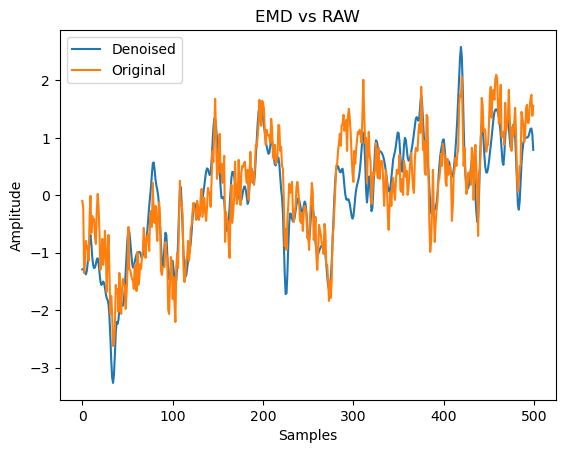

array([-1.28998838, -1.28114982, -1.29844043, ..., -0.43762144,
       -0.45408966, -0.46928663])

In [13]:
import matplotlib.pyplot as plt
emd_plotted = results_emd_dataset[0]['denoised_signals'][0]
plt.plot(emd_plotted[:500], label = "Denoised")
plt.plot(original_eeg[0][:500], label="Original")
plt.legend()
plt.title("EMD vs RAW")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

emd_plotted

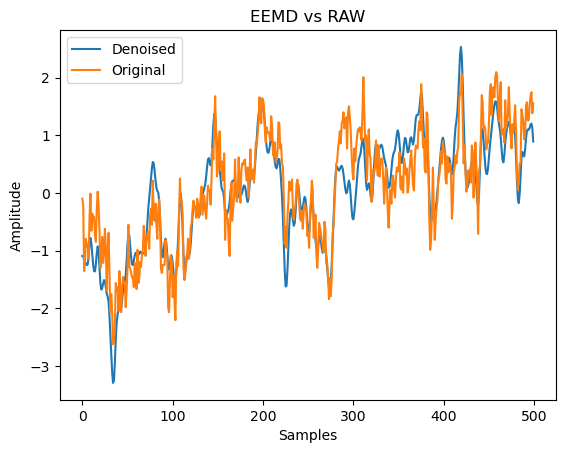

In [14]:
denoised_plotted = results_eemd[0]['denoised_signals'][0]

plt.plot(denoised_plotted[:500], label="Denoised")
plt.plot(original_eeg[0][:500], label="Original")
plt.legend()
plt.title("EEMD vs RAW")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


# Power Spectral Decomposition

In [15]:
results_eemd[0]

{'parameter_sets': [0.4, 0.3, 0.2, 0.1, 0.05],
 'denoised_signals': [array([-1.09100223, -1.09414883, -1.15214911, ..., -0.46118872,
         -0.52567048, -0.55138471]),
  array([-1.14241353, -1.15047936, -1.2074036 , ..., -0.38966825,
         -0.44132918, -0.48203053]),
  array([-1.15443243, -1.18596569, -1.24202166, ..., -0.40881939,
         -0.43312093, -0.45357949]),
  array([-1.21658189, -1.24701516, -1.27961855, ..., -0.43975434,
         -0.46796927, -0.48914698]),
  array([-1.24992262, -1.28067374, -1.30745224, ..., -0.43748898,
         -0.45587443, -0.46802518])]}

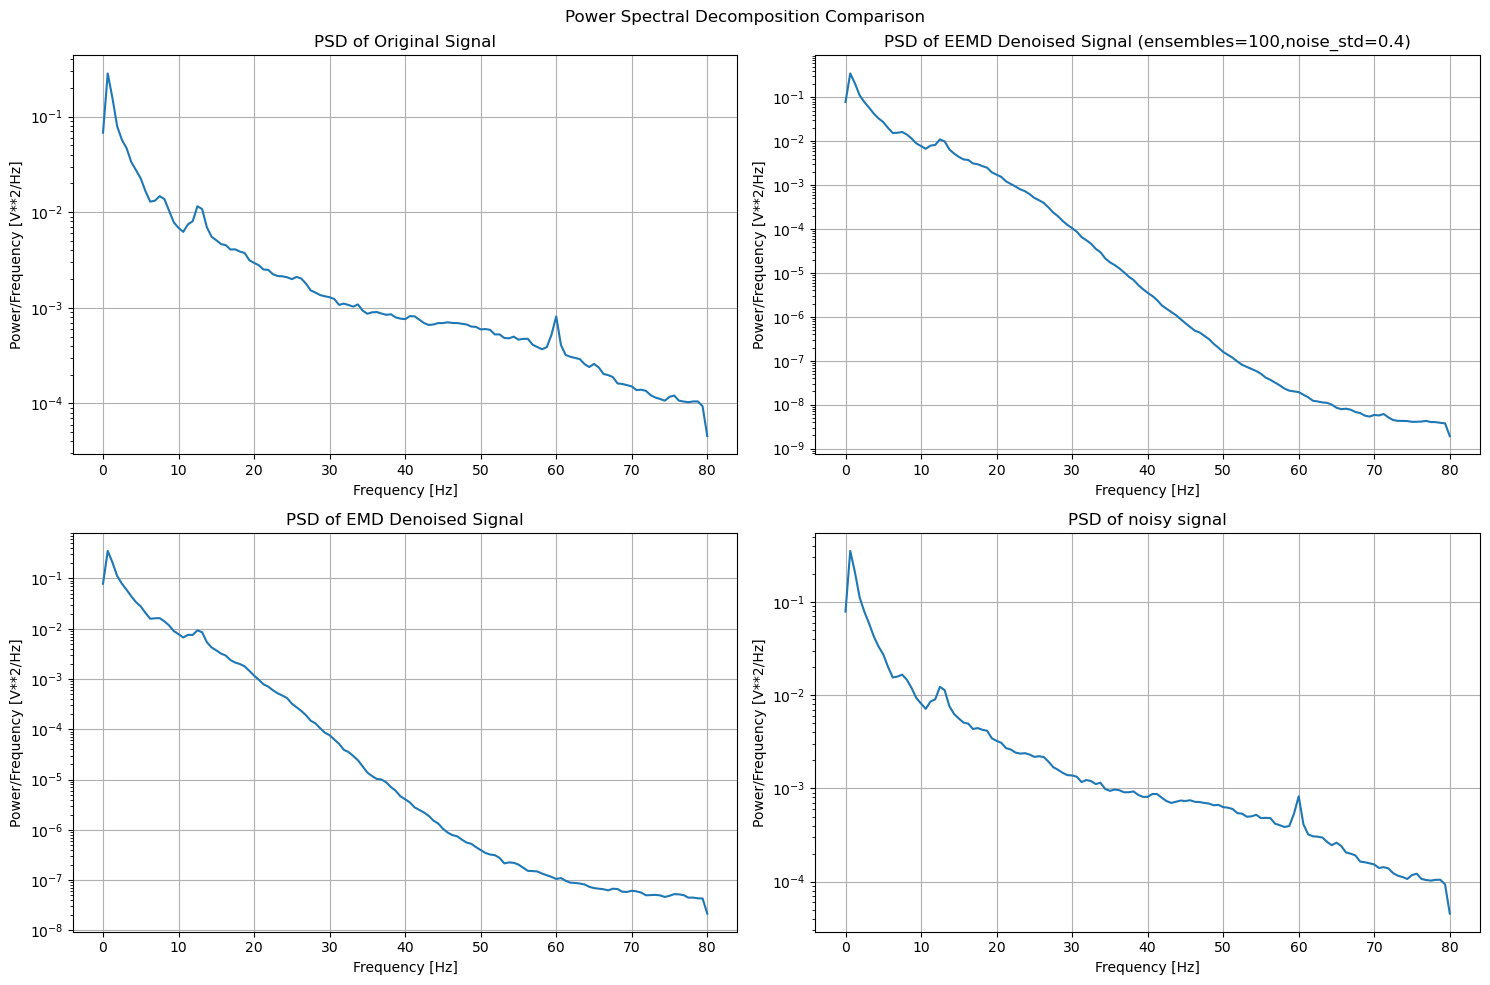

In [16]:
from scipy.signal import welch
psd_og_signal = original_eeg[0]
psd_eemd_signal = results_eemd[0]['denoised_signals'][0]
psd_noisy_signal = noisy_eeg[0]
psd_emd_signal = results_emd_dataset[0]['denoised_signals'][0]
plt.figure(figsize=(15, 10))
f1, Pxx1 = welch(psd_og_signal, fs=160)
f2, Pxx2 = welch(psd_eemd_signal, fs=160)
f3, Pxx3 = welch(psd_emd_signal, fs=160)
f4, Pxx4 = welch(psd_noisy_signal, fs=160)
plt.subplot(2,2,1)
plt.suptitle("Power Spectral Decomposition Comparison")
plt.semilogy(f1, Pxx1)
plt.title(f'PSD of Original Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,2)
plt.semilogy(f2, Pxx2)
plt.title(f'PSD of EEMD Denoised Signal (ensembles=100,noise_std=0.4)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,3)
plt.semilogy(f3, Pxx3)
plt.title(f'PSD of EMD Denoised Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.subplot(2,2,4)
plt.semilogy(f4, Pxx4)
plt.title(f'PSD of noisy signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [V**2/Hz]')
plt.grid()
plt.tight_layout()

plt.show()